In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import mplfinance as mpf

In [ ]:
class TickerData:
    def __init__(self, file_path, start_time=time(8, 0, 0), end_time=time(15, 59, 0)):
        self.file_path = file_path
        self.start_time = start_time
        self.end_time = end_time
        self.dataframes = self._load_data()
        self.blocks_dataframes = {}

    def _load_data(self):
        """
        Loads data from all CSV or TXT files in the specified directory.
        Each file's data is stored in a separate DataFrame.
        """
        try:
            if not os.path.exists(self.file_path):
                print(f"Error: Path does not exist: {self.file_path}")
                return None

            if not os.path.isdir(self.file_path):
                print(f"Error: The path is not a directory: {self.file_path}")
                return None

            dataframes = {}
            column_names = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

            for filename in os.listdir(self.file_path):
                file_full_path = os.path.join(self.file_path, filename)

                if not os.path.isfile(file_full_path):
                    continue

                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext == '.csv':
                    try:
                        df = pd.read_csv(file_full_path, delimiter=',')
                        df.columns = df.columns.str.strip()
                        dataframes[filename] = df
                        print(f"Loaded CSV file: {filename}")
                    except Exception as e:
                        print(f"Error loading CSV file {filename}: {e}")

                elif file_ext == '.txt':
                    try:
                        df = pd.read_csv(file_full_path, delimiter=',', names=column_names, header=None)
                        df['volume'] = np.nan
                        dataframes[filename] = df
                        print(f"Loaded TXT file: {filename}")
                    except Exception as e:
                        print(f"Error loading TXT file {filename}: {e}")

            if not dataframes:
                print(f"No CSV or TXT files found in directory: {self.file_path}")
                return None

            print(f"Successfully loaded data from {len(dataframes)} files.")
            return dataframes

        except Exception as e:
            print(f"Error loading files from directory {self.file_path}: {e}")
            return None

    def process_all_data(self, start_date, end_date):
        if not self.dataframes:
            print("No data to process.")
            return

        for filename, df in self.dataframes.items():
            print(f"\nProcessing data for {filename}")
            self.dataframes[filename] = self.process_data(df, start_date, end_date)

    def process_data(self, df, start_date, end_date):
        # Create an explicit copy to avoid chain indexing warnings
        df = df.copy()
        
        # Convert timestamp to datetime
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Filter by date range if needed
        # start_date = pd.to_datetime('2023-09-01')
        # end_date = pd.to_datetime('2023-09-05')
        df = df[(df['timestamp'] >= pd.to_datetime(start_date)) & (df['timestamp'] <= pd.to_datetime(end_date))].copy()

        # Convert columns to appropriate types
        for col in ['open', 'high', 'low', 'close']:
            if col in df.columns:
                df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

        # Filter by trading hours
        df = self.filter_trading_hours(df)

        # Add the one-minute range and classify observations
        df = self.add_range_and_classify(df)

        # Create 5-minute volume blocks and classify them
        df = self.classify_volume_blocks(df)

        print(f"Processed data shape: {df.shape}")
        return df

    def add_range_and_classify(self, df, threshold=0.1):
        """
        Adds a column for the one-minute range and classifies observations
        as Expansion (E), Contraction (C), or Steady (S).
        """
        # Calculate the one-minute range
        df['range'] = df['high'] - df['low']

        # Initialize the observation column
        df['range_obs'] = 'S'  # Default to Steady

        # Classify observations based on range changes
        for i in range(1, len(df)):
            if pd.notna(df.loc[i, 'range']) and pd.notna(df.loc[i - 1, 'range']):
                change = df.loc[i, 'range'] - df.loc[i - 1, 'range']
                if change > threshold:
                    df.loc[i, 'range_obs'] = 'E'  # Expansion
                elif change < -threshold:
                    df.loc[i, 'range_obs'] = 'C'  # Contraction

        return df

    def classify_volume_blocks(self, df):
        """
        Classifies each 5-minute block based on volume changes as Increasing (I), Decreasing (D), or Steady (S).
        """
        # Create 5-minute blocks
        df['block'] = df['timestamp'].dt.floor('5min')
        volume_obs = []

        for block_time, group in df.groupby('block'):
            if len(group) < 5:
                continue

            volumes = group['volume'].values
            min_volume = volumes.min()
            max_volume = volumes.max()
            avg_volume = volumes.mean()

            # Calculate squared distances for each scenario
            expanding_volumes = np.linspace(min_volume, max_volume, 5)
            contracting_volumes = np.linspace(max_volume, min_volume, 5)
            steady_volumes = np.full(5, avg_volume)

            expanding_distance = np.sum((volumes - expanding_volumes) ** 2)
            contracting_distance = np.sum((volumes - contracting_volumes) ** 2)
            steady_distance = np.sum((volumes - steady_volumes) ** 2)

            # Determine the classification
            if expanding_distance <= contracting_distance and expanding_distance <= steady_distance:
                classification = 'I' # 'Increasing'
            elif contracting_distance <= expanding_distance and contracting_distance <= steady_distance:
                classification = 'D' # 'Decreasing'
            else:
                classification = 'S' # 'Steady'

            volume_obs.append((block_time, classification))

        # Add classification to DataFrame
        classifications_df = pd.DataFrame(volume_obs, columns=['block', 'volume_obs'])
        df = df.merge(classifications_df, on='block', how='left')

        # Drop the 'block' column
        df = df.drop(columns=['block'])

        return df

    def filter_trading_hours(self, df):
        df = df.copy()
        df.loc[:, 'time_only'] = df['timestamp'].dt.time
        df = df[(df['time_only'] >= self.start_time) & (df['time_only'] <= self.end_time)].copy()
        df.drop('time_only', axis=1, inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

    # def create_10min_blocks_all(self):
    #     for filename, df in self.dataframes.items():
    #         print(f"\nCreating 10-minute blocks for {filename}")
    #         self.blocks_dataframes[filename] = self.create_10min_blocks(df)

    def create_10min_blocks_ndx(self):
        """
        Creates 10-minute blocks only for NDX data files.
        """
        for filename, df in self.dataframes.items():
            if "NDX" in filename:
                print(f"\nCreating 10-minute blocks for {filename}")
                self.blocks_dataframes[filename] = self.create_10min_blocks(df)


    def create_10min_blocks(self, df, window_size=10, step_size=1):
        """
        Creates the rolling 10-minute blocks.
        """
        df_copy = df.copy().sort_values('timestamp')
        windows_data = []
        
        # Define the frequency string based on step_size
        freq = f'{step_size}min'
        
        # Generate start times with the specified step size
        start_times = pd.date_range(
            df_copy['timestamp'].min(),
            df_copy['timestamp'].max() - pd.Timedelta(minutes=window_size),
            freq=freq
        )
        
        for start_time in start_times:
            end_time = start_time + pd.Timedelta(minutes=window_size)
            window_data = df_copy[(df_copy['timestamp'] >= start_time) & (df_copy['timestamp'] < end_time)]
            
            if window_data.empty:
                continue
                
            window_stats = {
                'window_start_time': start_time,
                'window_end_time': end_time,
                'open': window_data.iloc[0]['open'],
                'high': window_data['high'].max(),
                'low': window_data['low'].min(),
                'close': window_data.iloc[-1]['close'],
                'volume': window_data['volume'].sum(),
                'range': window_data['high'].max() - window_data['low'].min()
            }
            
            windows_data.append(window_stats)
        blocks_df = pd.DataFrame(windows_data)
        
        # Drop these cols that were used to calc 10mins with missing 1mins
        blocks_df.drop(columns=['average_open', 'average_close'], inplace=True, errors='ignore')
        
        return blocks_df

    def classify_ndx_volatility(self):
        """
        Classifies each 10-minute period of the NDX index based on range volatility.
        """
        for filename, blocks_df in self.blocks_dataframes.items():
            if "NDX" not in filename or blocks_df.empty:
                continue

            print(f"Classifying volatility for {filename}")

            # Calculate the range for each 10-minute block
            ranges = blocks_df['range'].sort_values()

            # Determine thresholds for low, normal, and high volatility
            low_threshold = ranges.iloc[85 * len(ranges) // 100]
            high_threshold = ranges.iloc[98 * len(ranges) // 100]

            # Classify each block based on the range
            def classify_range(range_value):
                if range_value <= low_threshold:
                    return 'L'  # Low volatility
                elif range_value <= high_threshold:
                    return 'N'  # Normal volatility
                else:
                    return 'H'  # High volatility

            blocks_df['hs_vol'] = blocks_df['range'].apply(classify_range)

            # Update the DataFrame with the classification
            self.blocks_dataframes[filename] = blocks_df

    def plot_1min_data(self):
        """
        Plots the 1-minute data for each security (excluding NDX).
        """
        # Filter out NDX files and get only non-empty dataframes
        non_ndx_files = [(name, df) for name, df in self.dataframes.items() 
                        if "NDX" not in name and not df.empty]
        
        if not non_ndx_files:
            print("No non-NDX files with 1-minute data to plot.")
            return
        
        num_plots = len(non_ndx_files)
        cols = 3
        rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed
        fig, axs = plt.subplots(rows, cols, figsize=(18, 6 * rows))
        axs = axs.flatten() if num_plots > 1 else [axs]
        plot_index = 0
        for filename, df in non_ndx_files:
            ohlc_data = df[['timestamp', 'open', 'high', 'low', 'close']].copy()
            ohlc_data.set_index('timestamp', inplace=True)
            
            mpf.plot(ohlc_data, type='candle', style='yahoo',
                    ylabel='Price ($)',
                    ax=axs[plot_index],
                    volume=False)

            axs[plot_index].set_title(f'{filename} 1-Minute Data')
            axs[plot_index].grid(True)
            plot_index += 1

        for j in range(plot_index, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        print('Check the directory for the 1min plots viz')
        if not os.path.exists('figs'):
            os.makedirs('figs')
            print("Created 'figs' directory")
        plt.savefig('figs/security_1min_plots.png')
        plt.show(block=False)
        plt.close(fig)
        return

    def create_hmm_table(self, start_time, end_time):
        """
        Creates a table showing range_obs and volume_obs for each security during the specified time period,
        plus the NDX hidden state volatility (hs_vol).
        Rows are ticker symbols and columns are timestamps.
        """
        # Check if dataframes exist
        if not self.dataframes:
            print("No data available for creating observation table.")
            return pd.DataFrame()  # Return empty DataFrame
            
        all_observations = pd.DataFrame()
        
        # Generate time range
        time_range = pd.date_range(start=start_time, end=end_time, freq='1min')
        time_cols = [t.strftime('%H:%M:%S') for t in time_range]
        
        # Filter out NDX files
        non_ndx_files = {name: df for name, df in self.dataframes.items() if "NDX" not in name}
        
        # For each security, extract the observations
        rows = []
        for security, df in non_ndx_files.items():
            # Extract just the ticker symbol from the filename
            ticker = security.split('_')[0]
            
            # Filter the dataframe to the specified time range
            filtered_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)].copy()
            
            if filtered_df.empty:
                continue
                
            # Create a row for range observations
            if 'range_obs' in filtered_df.columns:
                range_row = {'Observation': f"{ticker}_range"}
                filtered_df['time_str'] = filtered_df['timestamp'].dt.strftime('%H:%M:%S')
                for time_str in time_cols:
                    matching_rows = filtered_df[filtered_df['time_str'] == time_str]
                    if not matching_rows.empty:
                        range_row[time_str] = matching_rows.iloc[0]['range_obs']
                    else:
                        range_row[time_str] = None
                rows.append(range_row)
            
            # Create a row for volume observations
            if 'volume_obs' in filtered_df.columns:
                volume_row = {'Observation': f"{ticker}_volume"}
                for time_str in time_cols:
                    matching_rows = filtered_df[filtered_df['time_str'] == time_str]
                    if not matching_rows.empty:
                        volume_row[time_str] = matching_rows.iloc[0]['volume_obs']
                    else:
                        volume_row[time_str] = None
                rows.append(volume_row)
        
        # Add NDX hidden state volatility (hs_vol) from blocks_dataframes
        ndx_blocks = None
        for filename, blocks_df in self.blocks_dataframes.items():
            if "NDX" in filename and 'hs_vol' in blocks_df.columns:
                ndx_blocks = blocks_df.copy()
                break
        
        if ndx_blocks is not None and not ndx_blocks.empty:
            ndx_vol_row = {'Observation': "NDX_volatility"}
            
            # For each minute in our time range
            for t in time_range:
                time_str = t.strftime('%H:%M:%S')
                
                # Find the 10-minute block that contains this minute
                matching_blocks = ndx_blocks[
                    (ndx_blocks['window_start_time'] <= t) & 
                    (ndx_blocks['window_end_time'] > t)
                ]
                
                if not matching_blocks.empty:
                    ndx_vol_row[time_str] = matching_blocks.iloc[0]['hs_vol']
                else:
                    ndx_vol_row[time_str] = None
            
            rows.append(ndx_vol_row)
        
        result_table = pd.DataFrame(rows)
        if not result_table.empty:
            result_table.set_index('Observation', inplace=True)
        
        return result_table
    
    def save_hmm_table(self, start_time, end_time, filename="hmm_model.csv"):
        """
        Creates an file with the data queried by the create_hmm_table() in the directory 
        specified by self.file_path.
        """
        # Create the HMM table
        hmm_table = self.create_hmm_table(start_time, end_time)
        
        if hmm_table.empty:
            print("No data available to save.")
            return None
        
                # Print the table to the terminal
        print("\n===== HMM Observations Table =====")
        print(hmm_table)
        print("==================================\n")

        # Create the full path for saving the file
        if not os.path.exists('model'):
            os.makedirs('model')
            print("Created 'model' directory")
        output_path = os.path.join('model', filename)
        
        # Save the table to CSV
        hmm_table.to_csv(output_path)
        print(f"HMM observations table saved to: {output_path}")
        
        return output_path




In [3]:
# Where is your data from the directory that this notebook is in?
# Instantiates a class object
# Loads the csv and txt files from that directory
ticker_data = TickerData("./data")

Loaded CSV file: TSLA_1min_firstratedata.csv
Loaded TXT file: NDX_full_1min.txt
Loaded CSV file: MSFT_1min_firstratedata.csv
Loaded CSV file: AAPL_1min_firstratedata.csv
Loaded CSV file: QQQ_1min_firstratedata.csv
Loaded CSV file: VXX_1min_firstratedata.csv
Loaded CSV file: AMZN_1min_firstratedata.csv
Successfully loaded data from 7 files.


In [4]:
# Loads data from files into dataframes
ticker_data.process_all_data('2023-09-01', '2023-09-05')



Processing data for TSLA_1min_firstratedata.csv
Processed data shape: (480, 9)

Processing data for NDX_full_1min.txt
Processed data shape: (390, 9)

Processing data for MSFT_1min_firstratedata.csv
Processed data shape: (459, 9)

Processing data for AAPL_1min_firstratedata.csv
Processed data shape: (480, 9)

Processing data for QQQ_1min_firstratedata.csv
Processed data shape: (480, 9)

Processing data for VXX_1min_firstratedata.csv
Processed data shape: (444, 9)

Processing data for AMZN_1min_firstratedata.csv
Processed data shape: (476, 9)


Check the directory for the 1min plots viz


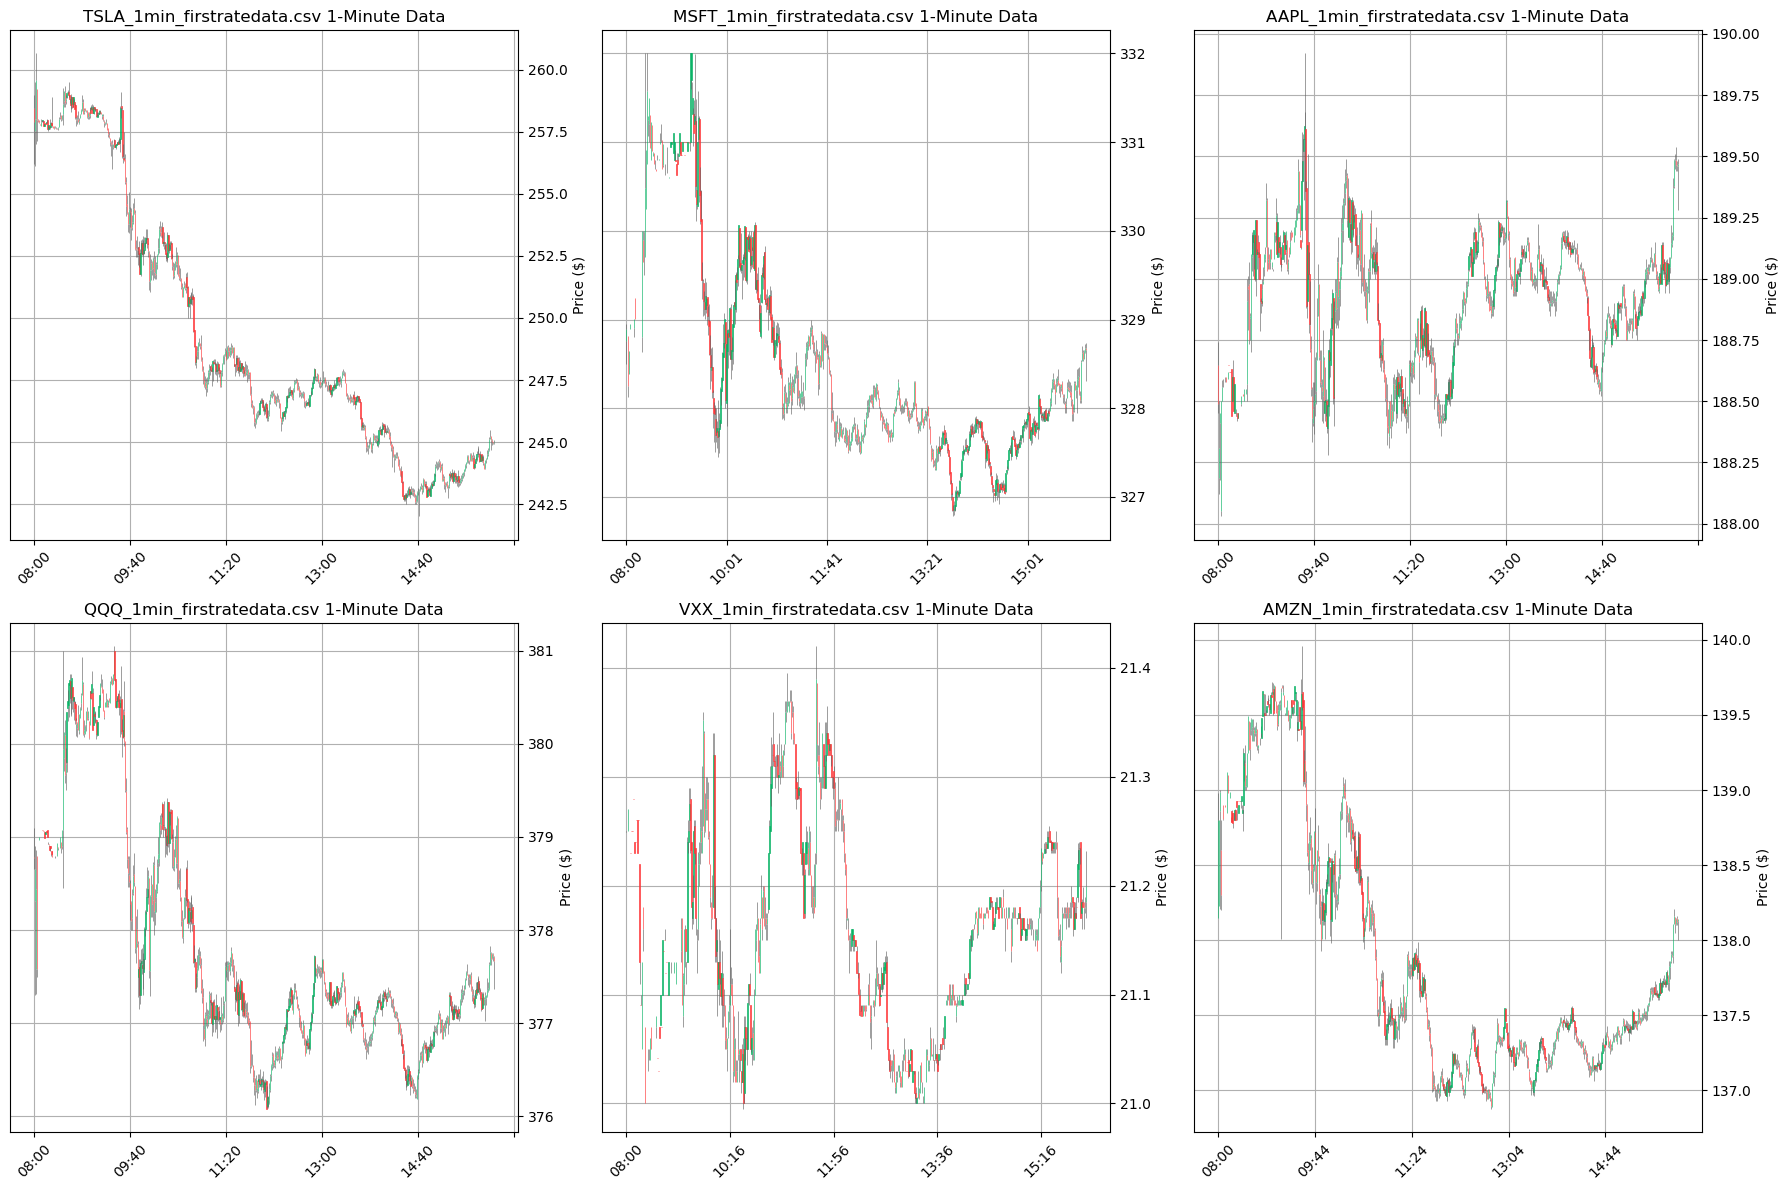

In [5]:
# Plot a sample of the 1 minute data from the loaded files to a figure and save it to the figs dir
ticker_data.plot_1min_data()

In [6]:
# Creates rolling 10min block for the NDX
ticker_data.create_10min_blocks_ndx()

# Calculates the hidden states (target) from the 10min block range size
ticker_data.classify_ndx_volatility()

# Display the 10-minute blocks for NDX with hidden state volatility classification
for filename in ticker_data.blocks_dataframes:
    if "NDX" in filename:
        blocks_df = ticker_data.blocks_dataframes[filename]  # Get fresh reference
        print(f"\n10-minute blocks for {filename} with volatility classification:")
        try:
            print(blocks_df[['window_start_time', 'window_end_time', 'open', 'high', 'low', 'close', 'volume', 'range', 'hs_vol']].head())
        except KeyError as e:
            print(f"Error: {e}")
            print("Available columns:", blocks_df.columns)


Creating 10-minute blocks for NDX_full_1min.txt
Classifying volatility for NDX_full_1min.txt

10-minute blocks for NDX_full_1min.txt with volatility classification:
    window_start_time     window_end_time      open      high       low  \
0 2023-09-01 09:30:00 2023-09-01 09:40:00  15600.95  15618.85  15527.47   
1 2023-09-01 09:31:00 2023-09-01 09:41:00  15604.75  15618.85  15514.90   
2 2023-09-01 09:32:00 2023-09-01 09:42:00  15596.21  15612.82  15509.57   
3 2023-09-01 09:33:00 2023-09-01 09:43:00  15590.66  15612.82  15509.57   
4 2023-09-01 09:34:00 2023-09-01 09:44:00  15601.78  15612.82  15509.57   

      close  volume   range hs_vol  
0  15530.40     0.0   91.38      H  
1  15517.11     0.0  103.95      H  
2  15510.85     0.0  103.25      H  
3  15520.01     0.0  103.25      H  
4  15528.97     0.0  103.25      H  


In [7]:
# Define the time range we want to display
start_time = pd.Timestamp('2023-09-01 09:30:00')
end_time = start_time + timedelta(minutes=30)

# Create and display the observation table
ticker_data.save_hmm_table(start_time, end_time)


===== HMM Observations Table =====
               09:30:00 09:31:00 09:32:00 09:33:00 09:34:00 09:35:00 09:36:00  \
Observation                                                                     
TSLA_range            E        C        E        C        E        S        E   
TSLA_volume           D        D        D        D        D        S        S   
MSFT_range            E        C        C        C        E        C        E   
MSFT_volume           D        D        D        D        D        D        D   
AAPL_range            E        S        S        C        E        C        S   
AAPL_volume           D        D        D        D        D        D        D   
QQQ_range             E        E        C        S        E        C        S   
QQQ_volume            D        D        D        D        D        S        S   
VXX_range             S        S        S        S        S        S        S   
VXX_volume            D        D        D        D        D        S     

'model/hmm_model.csv'